In [1]:
%matplotlib inline

In [2]:
import numpy as np # linear algebra
import seaborn as sns
sns.set(style='whitegrid')
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
allData = pd.read_csv('/srv/p2pRisk/spider-wdzj/datas/total.csv')

In [4]:
allData.shape

(4828, 17)

In [5]:
allData.head()

,wdzjPlatId,platName,isBroken,amount,avgBidMoney,avgBorrowMoney,bidderNum,borrowerNum,currentLeverageAmount,fullloanTime,netInflowOfThirty,incomeRate,loanPeriod,stayStillOfTotal,top10DueInProportion,top10StayStillProportion,totalLoanNum
0,34,麦子金服财富,0,107682.83,2.75,0.55,39202,194058,56.90,62.26,-739.59,15.85,28.47,614470.47,56.81,0.14,568470
1,34,麦子金服财富,0,93424.78,2.14,0.47,43699,197817,50.43,55.93,651.62,14.59,26.96,544590.68,57.00,0.13,619547
2,37,瑞银创投,0,4215.00,21.62,91.63,195,46,7.90,914.73,84.21,12.53,2.32,12246.15,48.62,29.48,69
3,37,瑞银创投,0,4922.00,24.61,86.35,200,57,7.82,878.21,103.22,12.58,2.57,12124.86,49.49,29.27,73
4,37,瑞银创投,0,4429.00,21.93,85.17,202,52,7.64,1632.82,-27.30,13.08,4.42,11848.88,48.54,28.20,68


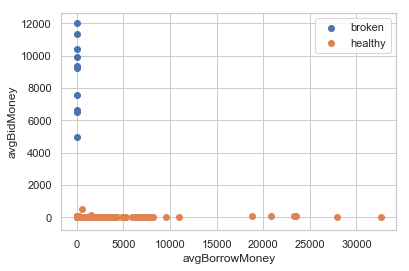

In [6]:
# broken = allData[:836]
# print(allData)
plt.scatter(allData[:836].avgBorrowMoney, allData[:836].avgBidMoney, label='broken')
plt.scatter(allData[837:].avgBorrowMoney, allData[837:].avgBidMoney, label='healthy')
plt.xlabel('avgBorrowMoney')
plt.ylabel('avgBidMoney')
plt.legend(loc='best')

In [7]:
'''
只去除'wdzjPlatId', 'platName', 'isBroken'
准确度只有 0.5738318

去除以下参数的训练后 latest判断准确度提高到了 0.69719625 提高了0.12336445
'avgBorrowMoney', 'avgBidMoney', 'bidderNum', 'borrowerNum'

在去除amount参数后 准确度下降到了 0.66542053

增加了netInflowOfThirty（资金净流入）参数之后 什么参数都不去除的情况下
准确度达到0.7084112
但是发现预测出来的最新的内容全部都是没有风险的情况，isBroken: 0
所以可能过拟合

'''
# dropIndex = ['wdzjPlatId', 'platName', 'isBroken']

# dropIndex = ['wdzjPlatId', 'platName', 'isBroken', 'avgBorrowMoney', 'avgBidMoney', 'bidderNum', 'borrowerNum']

totalIndexNum = 17
dropIndex = ['wdzjPlatId', 'platName', 'isBroken']
featureNum = totalIndexNum - len(dropIndex)
X = allData.drop(labels=dropIndex, axis=1).values
y = allData.isBroken.values
print(len(X[0]))

14


In [8]:
'''
trainset: 80%
testset: 20%
set seed for numpy and tensorflow
set for reproducible results
'''
seed = 5
np.random.seed(seed)
tf.set_random_seed(seed)

In [9]:
# set replace=False, Avoid double sampling
train_index = np.random.choice(len(X), round(len(X) * 0.8), replace=False)

In [10]:
# diff set
test_index = np.array(list(set(range(len(X))) - set(train_index)))
train_X = X[train_index]
train_y = y[train_index]
test_X = X[test_index]
test_y = y[test_index]

In [11]:
# Define the normalized function
def min_max_normalized(data):
    col_max = np.max(data, axis=0)
    col_min = np.min(data, axis=0)
    return np.divide(data - col_min, col_max - col_min)

In [12]:
# Normalized processing, must be placed after the data set segmentation, 
# otherwise the test set will be affected by the training set
train_X = min_max_normalized(train_X)
test_X = min_max_normalized(test_X)

In [13]:
# Begin building the model framework
# Declare the variables that need to be learned and initialization
# There are ${featureNum} features here, A's dimension is (${featureNum}, 1)
A = tf.Variable(tf.random_normal(shape=[featureNum, 1]))
b = tf.Variable(tf.random_normal(shape=[1, 1]))
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

Instructions for updating:
Colocations handled automatically by placer.


In [14]:
# Define placeholders
data = tf.placeholder(dtype=tf.float32, shape=[None, featureNum])
target = tf.placeholder(dtype=tf.float32, shape=[None, 1])

In [15]:
# Declare the model you need to learn
mod = tf.matmul(data, A) + b

In [16]:
# Declare loss function
# Use the sigmoid cross-entropy loss function,
# first doing a sigmoid on the model result and then using the cross-entropy loss function
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=mod, labels=target))

In [17]:
# Define the learning rate， batch_size etc.
learning_rate = 0.001
batch_size = 30
iter_num = 6000

In [18]:
# Define the optimizer
opt = tf.train.GradientDescentOptimizer(learning_rate)
# opt = tf.train.MomentumOptimizer(learnin )

In [19]:
# Define the goal
goal = opt.minimize(loss)

In [20]:
# Define the accuracy
# The default threshold is 0.5, rounded off directly
prediction = tf.round(tf.sigmoid(mod))
# Bool into float32 type
correct = tf.cast(tf.equal(prediction, target), dtype=tf.float32)
# Average
accuracy = tf.reduce_mean(correct)
# End of the definition of the model framework

In [21]:
# Start training model
# Define the variable that stores the result
loss_trace = []
train_acc = []
test_acc = []

In [22]:
# training model
for epoch in range(iter_num):
    # Generate random batch index
    batch_index = np.random.choice(len(train_X), size=batch_size)
    batch_train_X = train_X[batch_index]
    batch_train_y = np.matrix(train_y[batch_index]).T
    sess.run(goal, feed_dict={data: batch_train_X, target: batch_train_y})
    temp_loss = sess.run(loss, feed_dict={data: batch_train_X, target: batch_train_y})
    # convert into a matrix, and the shape of the placeholder to correspond
    temp_train_acc = sess.run(accuracy, feed_dict={data: train_X, target: np.matrix(train_y).T})
    temp_test_acc = sess.run(accuracy, feed_dict={data: test_X, target: np.matrix(test_y).T})
    # recode the result
    loss_trace.append(temp_loss)
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    # output
    if (epoch + 1) % 300 == 0:
        print('epoch: {:4d} loss: {:5f} train_acc: {:5f} test_acc: {:5f}'.format(epoch + 1, temp_loss,
                                                                          temp_train_acc, temp_test_acc))

epoch:  300 loss: 0.883109 train_acc: 0.208700 test_acc: 0.201863
epoch:  600 loss: 0.781738 train_acc: 0.321854 test_acc: 0.410973
epoch:  900 loss: 0.695862 train_acc: 0.605127 test_acc: 0.642857
epoch: 1200 loss: 0.665153 train_acc: 0.721906 test_acc: 0.733954
epoch: 1500 loss: 0.635438 train_acc: 0.774469 test_acc: 0.767081
epoch: 1800 loss: 0.505367 train_acc: 0.803988 test_acc: 0.795031
epoch: 2100 loss: 0.513807 train_acc: 0.834283 test_acc: 0.838509
epoch: 2400 loss: 0.512398 train_acc: 0.848524 test_acc: 0.858178
epoch: 2700 loss: 0.479539 train_acc: 0.857587 test_acc: 0.860248
epoch: 3000 loss: 0.531235 train_acc: 0.857846 test_acc: 0.860248
epoch: 3300 loss: 0.493633 train_acc: 0.858105 test_acc: 0.860248
epoch: 3600 loss: 0.384595 train_acc: 0.858622 test_acc: 0.860248
epoch: 3900 loss: 0.551451 train_acc: 0.858622 test_acc: 0.860248
epoch: 4200 loss: 0.408606 train_acc: 0.858364 test_acc: 0.861284
epoch: 4500 loss: 0.380586 train_acc: 0.858364 test_acc: 0.861284
epoch: 480

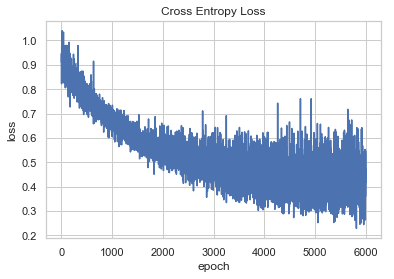

In [23]:
# Visualization of the results
# loss function
plt.plot(loss_trace)
plt.title('Cross Entropy Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

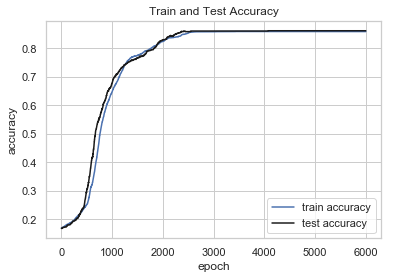

In [24]:
# accuracy
plt.plot(train_acc, 'b-', label='train accuracy')
plt.plot(test_acc, 'k-', label='test accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Train and Test Accuracy')
plt.legend(loc='best')
plt.show()

In [25]:
latestData = pd.read_csv('/srv/p2pRisk/spider-wdzj/datas/latest.csv')
latestData.shape

(535, 17)

In [26]:
latestTestX = latestData.drop(labels=dropIndex, axis=1).values
latestTestY = latestData.isBroken.values
acc = sess.run(accuracy, feed_dict={data: latestTestX, target: np.matrix(latestTestY).T})
print(acc)

0.7084112


In [27]:
pred = sess.run(prediction, feed_dict={data: latestTestX})

In [28]:
print(pred)

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.